In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bats
from sklearn.decomposition import PCA
vhsize = (1024,1536)
np.random.seed(42)

The following code will load images from the VanHateren Data Set

In [2]:
fname = '/run/media/brad/e1fcca6c-f010-49b7-9dd6-d7f386f46bed/data/image/vanhateren_iml/imk00002.iml'
img = np.fromfile(fname, dtype='>i2') # stored in big-endian byte order, 2 bytes per pixel

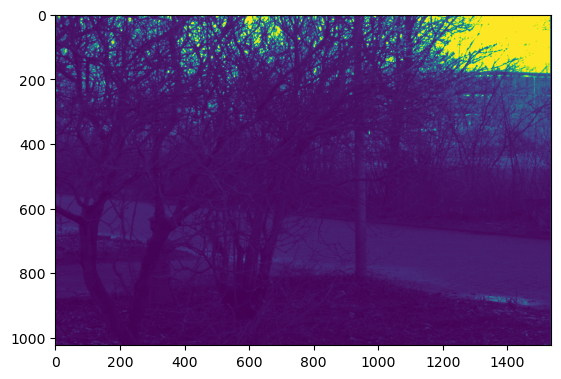

In [3]:
img2 = img.reshape(*vhsize)
plt.imshow(img2)
plt.show()

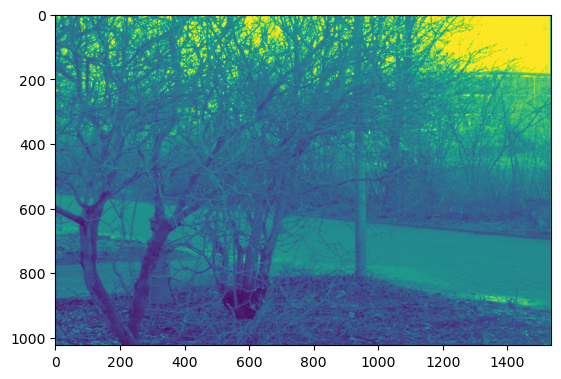

In [4]:
img2 = np.log(1.0*img2 + 1)
plt.imshow(img2)
plt.show()

In [5]:
def read_iml(fname):
    vhsize = (1024,1536)
    img = np.fromfile(fname, dtype='>i2')
    img2 = img.reshape(*vhsize)
    return img2

def gen_img_vh_fname(img_n, root_dir='.'):
    """
    generate file path to image
    """
    return root_dir + "/imk{:05d}.iml".format(img_n)

root_dir = '/run/media/brad/e1fcca6c-f010-49b7-9dd6-d7f386f46bed/data/image/vanhateren_iml'
gen_img_vh_fname(100, root_dir)

'/run/media/brad/e1fcca6c-f010-49b7-9dd6-d7f386f46bed/data/image/vanhateren_iml/imk00100.iml'

In [6]:
def sample_voxels(img, n_samples=5000, dims=(5,5)):
    """
    sample voxel patches of size dims from image
    """
    idims = img.shape
    d = len(img.shape)
    m = np.prod(dims)
    data = np.empty((n_samples, m), dtype=np.float64)
    for s in range(n_samples):
        st_inds = [np.random.randint(idims[i] - dims[i] - 1) for i in range(d)]
        data[s] = img[st_inds[0]:st_inds[0]+dims[0], st_inds[1]:st_inds[1] + dims[1]].flatten()
        
    return data

data = sample_voxels(img2)
data.shape

(5000, 25)

The following code generates data folloiwng Lee et al and Carlsson & DeSilva.

In [7]:
from tqdm import tqdm
def mean_center(data):
    """
    mean center each row of data
    """
    return data - data.mean(axis=1).reshape(-1,1)


def Laplacian(*shape):
    """
    return Laplacian on grid of size shape
    """
    D1 = np.diag(np.ones(shape[0]-1),1) + np.diag(np.ones(shape[0]-1), -1)
    I1 = np.eye(shape[0])
    
    D2 = np.diag(np.ones(shape[1]-1),1) + np.diag(np.ones(shape[1]-1), -1)
    I2 = np.eye(shape[1])

    A = np.kron(I1, D2) + np.kron(D1, I2)
    D = np.diag(np.sum(A, axis=1))
    return D - A


def contrast_norm(X, shape):
    """
    compute the contrast norm of each row of data
    
    X : n x d array
    shape: prod(shape) = d
    
    out[i] = X[i]^T @ L @ X[i]
    """
    L = Laplacian(*shape)
    XL = X @ L
    return (XL * X).sum(axis=1)
    

def filter_patches_contrast(data, dims=(5,5), sample_p=0.3, sample_thresh=0.0):
    """
    filter voxels based on contrast norm
    """
    cnorms = contrast_norm(data, dims)
    perm = np.argsort(cnorms)
    n_taken = round(len(data)*sample_p)
    return data[perm[-n_taken:]] # highest contrast patches
    

def normalize_contrast(data, dims=(5,5)):
    cnorms = contrast_norm(data, dims)
    return data / cnorms.reshape(-1,1)

def normalize_l2(data):
    norms = np.linalg.norm(data, axis=1)
    return data / norms.reshape(-1,1)
    

def lpm_sampling(img_n, n_samples, sample_p, dims=(5,5), root_dir='.'):
    fname = gen_img_vh_fname(img_n, root_dir)
    img = np.log(read_iml(fname) + 1.0)
    data = sample_voxels(img, n_samples, dims)
    data = mean_center(data)
    data = filter_patches_contrast(data, dims, sample_p)
    data = normalize_contrast(data, dims)
    return data
    

def gen_lpm_data(n_imgs, dims, root_dir='.'):
    n_imgs = min(n_imgs, 4212)
    n_samples = 1000
    X = np.zeros((0,np.prod(dims)))
    pic_n = 1
    for i in tqdm(range(1,n_imgs+1)):
        try:
            Y = lpm_sampling(i, 5000, 0.2, dims, root_dir=root_dir)
            X = np.vstack((X,Y))
        except:
            print("issue with picture {:05d}".format(i))
            pic_n
    return X

We'll now generate data using the LPM procedure

In [8]:
np.random.seed(42)
dims = (3, 3)
data = gen_lpm_data(200, dims, root_dir)
data.shape

100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


(200000, 9)

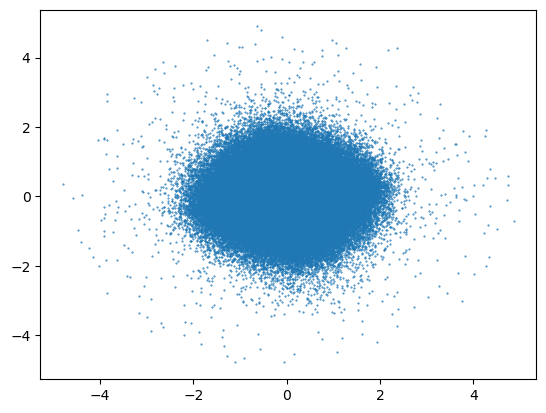

In [9]:
from sklearn.decomposition import PCA
X2 = PCA(n_components=2).fit_transform(data)
plt.scatter(X2[:,0], X2[:,1], s = 0.2)
plt.show()

shuffle the data and take a random subset

In [10]:
rng = np.random.default_rng(42) # random number generator with seed
rng.shuffle(data)
data.shape

(200000, 9)

In [11]:
n_samples = 50000
data2 = data[:n_samples]

In [12]:
import time
from scipy.spatial import cKDTree
def filter_voxels_codensity(data, k=10, p=0.3, **kwargs):
    """
    filter data to take top p fraction of distance to kth nearest neighbor
    
    kwargs passed to cKDTree query method.
    """
    tree = cKDTree(data)
    ds, nbrs = tree.query(data, k=k+1, **kwargs) # nearest neighbor is self, use all threads
    i = int(len(data)*p)
    inds = np.argsort(ds[:,-1])
    return data[inds[:i]]

we now filter voxels by codensity

In [13]:
k = 5
cut_p = 0.4
data3 = filter_voxels_codensity(normalize_l2(data2), k=k, p=cut_p, workers=-1)

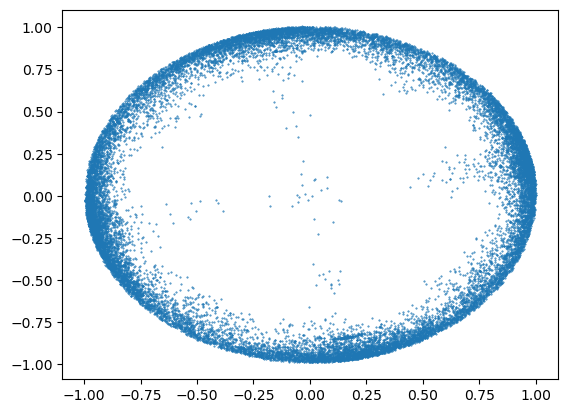

In [14]:
from sklearn.decomposition import PCA
X3 = PCA(n_components=2).fit_transform(data3)
plt.scatter(X3[:,0], X3[:,1], s = 0.2)
plt.show()

This puts data in DCT basis.  We project off the constant vector

In [15]:
from scipy.fftpack import dct
def dct_basis(dims):
    B = dct(np.eye(dims[0]))
    for d in dims[1:]:
        B = np.kron(dct(np.eye(d)), B)
    return B

def dct_basis_reduced(dims):
    """
    remove constant term from DCT basis
    """
    B = dct_basis(dims)
    return B[:,1:]

def dct_reduced(data, dims):
    B = dct_basis_reduced(dims)
    return data @ B
    
data4 = dct_reduced(data3, dims)
data4.shape

(20000, 8)

here's a visualization of the DCT basis

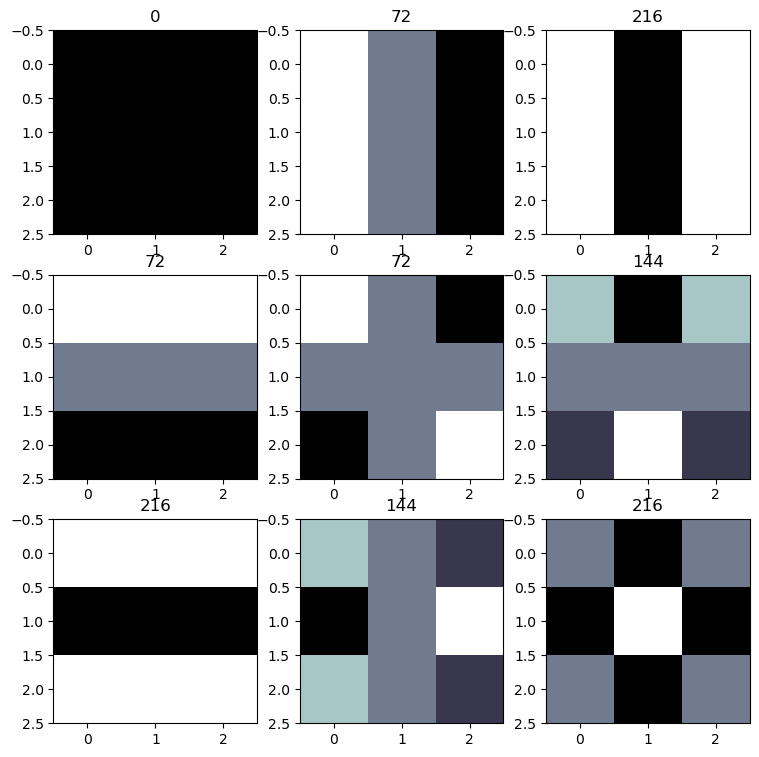

In [16]:
B = dct_basis(dims)
ns = contrast_norm(B.T, dims)

fig, ax = plt.subplots(*dims,figsize=(9,9))
k = 0
for i in range(dims[0]):
    for j in range(dims[1]):
        ax[i,j].imshow(B[:,k].reshape(*dims), cmap='bone')
        ax[i,j].set_title("{:.0f}".format(ns[k]))
        k = k + 1
        
plt.show()

Now let's look at some projections of our data in the DCT basis

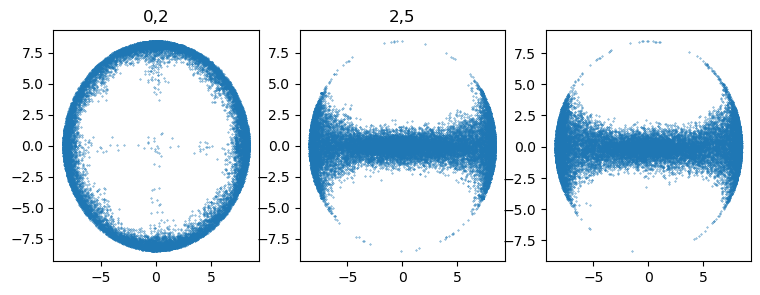

In [17]:
def plot_dct(data, dims, s=0.1):

    fig, ax = plt.subplots(1,3, figsize=(9,3))
    
    dim1 = 0
    dim2 = dims[0]-1
    ax[0].scatter(data[:,dim1], data[:,dim2],s=s)
    ax[0].set_title("{},{}".format(dim1, dim2))

    dim1 = 0
    dim2 = 1
    ax[1].scatter(data[:,dim1], data[:,dim2],s=s)
    ax[1].set_title("{},{}".format(dim1, dim2))

    dim1 = dims[0]-1
    dim2 = 2*dims[0]-1
    ax[2].scatter(data[:,dim1], data[:,dim2], s=s)
    ax[1].set_title("{},{}".format(dim1, dim2))
    return fig, ax

fig, ax = plot_dct(data4, dims)
plt.show()

Now let's do some greedy landmarking and compute PH

In [18]:
import bats

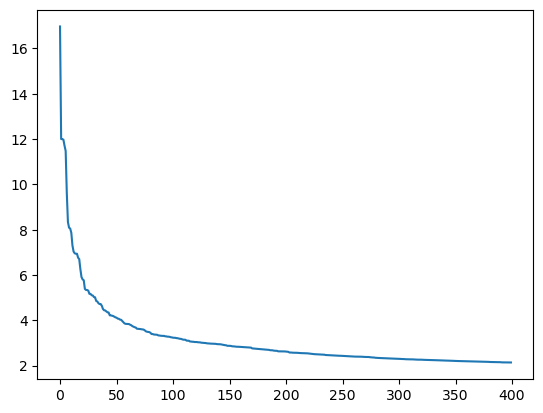

In [19]:
inds, ds = bats.greedy_landmarks_hausdorff(bats.DataSet(bats.Matrix(data4)), bats.Euclidean(), 0)
plt.plot(ds[:400])
plt.show()

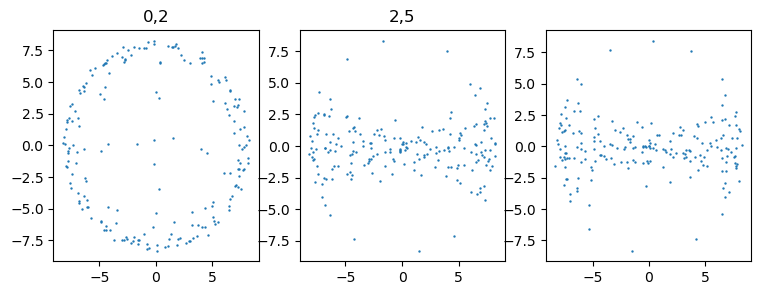

In [20]:
data5 = data4[inds[:200]]

fig, ax = plot_dct(data5, dims, s=0.5)
plt.show()

In [21]:
from scipy.spatial.distance import pdist, squareform

In [22]:
D = squareform(pdist(data5))
crit_rad = np.min(np.max(D, axis=1))
crit_rad

15.300701823962582

In [23]:
Dbats = bats.Matrix(D)
F = bats.RipsFiltration(Dbats, crit_rad, 2)

In [24]:
RC = bats.reduce(F, bats.F2(), bats.extra_reduction_flag(), bats.clearing_flag())

In [25]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)

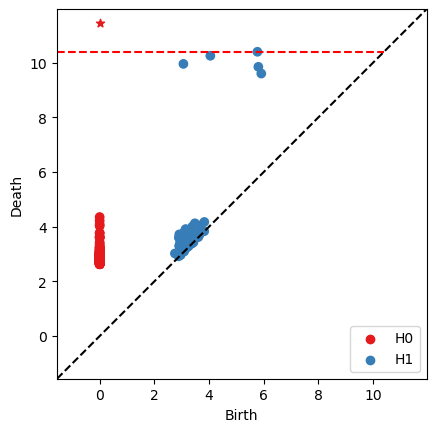

In [26]:
bats.persistence_diagram(ps)
plt.show()

3-circle model should have 5 prominent H1 - we see something like that here

In [27]:
for p in ps:
    if p.dim() == 1 and p.death() - p.birth() >= 2:
        print(p)

1 : (3.06183,9.95402) <261,127340>
1 : (4.04717,10.2507) <967,142259>
1 : (5.76877,10.3972) <2563,148784>
1 : (5.80322,9.84673) <2596,123380>
1 : (5.91022,9.60009) <2706,113042>


200 Points are still slow to run, so I subsampled to 100: `data6` .

In [29]:
import numpy as np
# Visualization
import plotly.express as px 
import matplotlib.pyplot as plt 
# from spectral_graph_embedding import plotly_3D_scatter 
from PH_projection_pursuit import bottleneck_proj_pursuit, subsample_bats
from sklearn.metrics.pairwise import pairwise_distances
import bats

1 : (3.93227,10.4224) <139,15665>
1 : (4.1251,10.4174) <176,15641>
1 : (5.76877,10.8803) <531,19154>
1 : (5.91022,9.69953) <561,11760>
1 : (5.91323,9.84673) <562,12359>


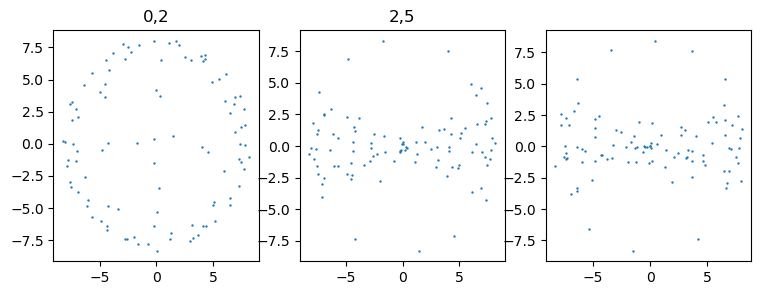

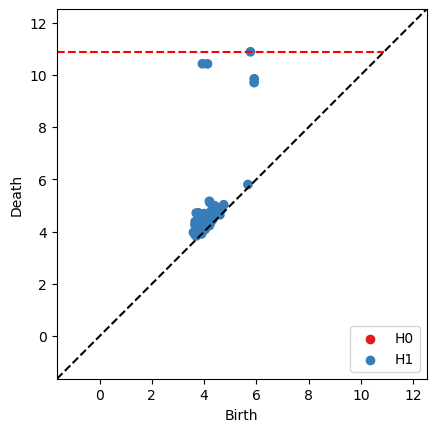

In [30]:
def PH_compute(X):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    # maixmum complex dimension = maximum homology dimension + 1
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    flags = (bats.extra_reduction_flag(), bats.clearing_flag())
    R = bats.reduce(F, bats.F2(), *flags)
    ps = R.persistence_pairs(1)

    fig, ax = bats.persistence_diagram(ps)

    for p in ps:
        if p.death() != np.inf and p.death() - p.birth() > 2:
    #     if p.dim() == 1 and p.death() != np.inf and p.death() - p.birth() > 1e-3:
            print(p)

data6 = data4[inds[:100]]

fig, ax = plot_dct(data6, dims, s=0.5)


PH_compute(data6)
plt.show()

In [31]:
data6.shape

(100, 8)

In [32]:
P, opt_info = bottleneck_proj_pursuit(data6, opt_dim = 10)

/home/brad/miniconda3/envs/bats/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180543123/work/c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


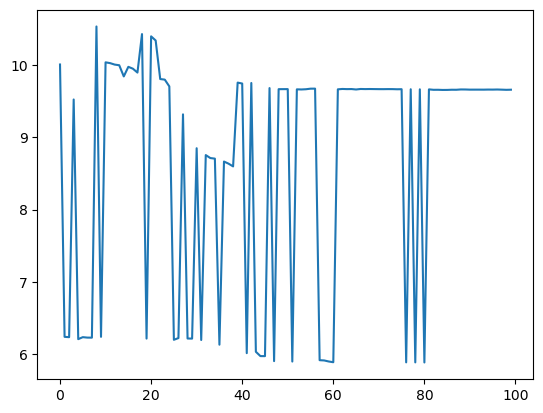

In [33]:
plt.plot(opt_info['losses'])
plt.show()

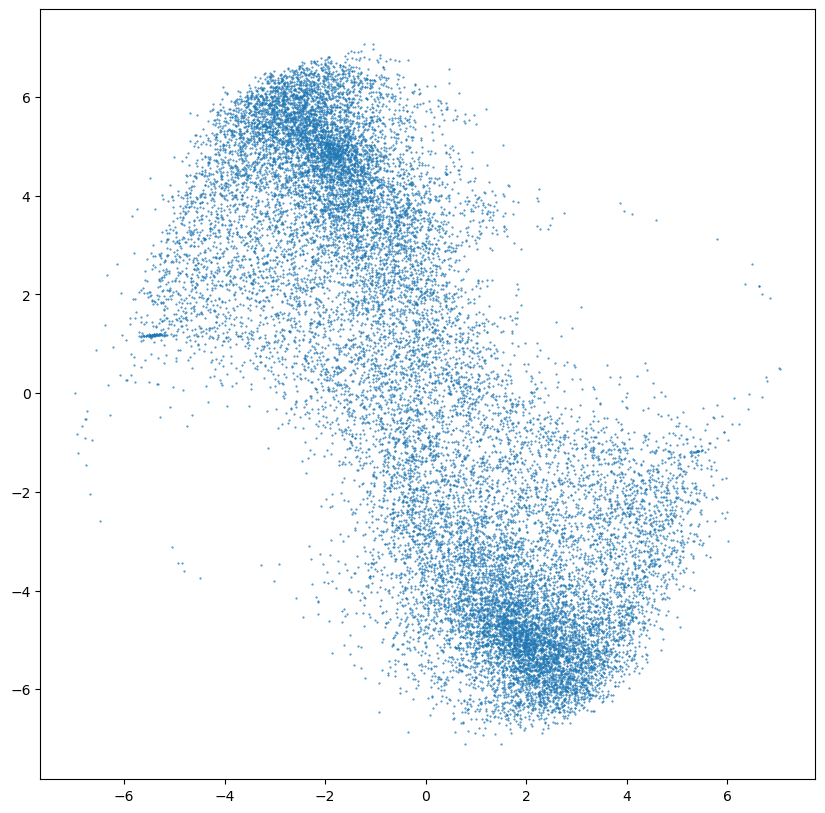

In [34]:
X_PH = data4 @ P.T
fig = plt.figure(figsize=(10,10))
plt.scatter(X_PH[:,0], X_PH[:,1], s = 0.2)
plt.show()

# Optimization with Cayley Update

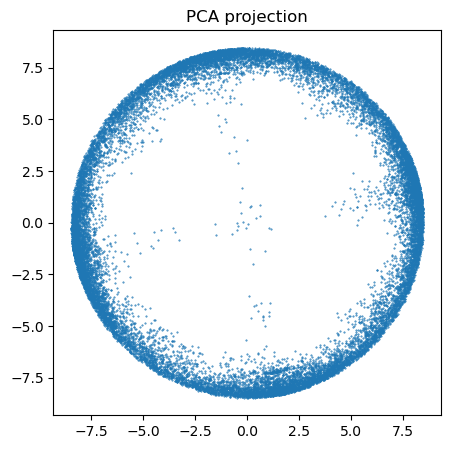

In [35]:
from cayley import cayley_update
from sklearn.decomposition import PCA # for PCA analysis
pca = PCA(n_components=2).fit(data4)

P = pca.components_
P = P.T
X_pca = data4 @ P
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_pca[:,0], X_pca[:,1], s = 0.2)
ax.set_title('PCA projection')
plt.show()

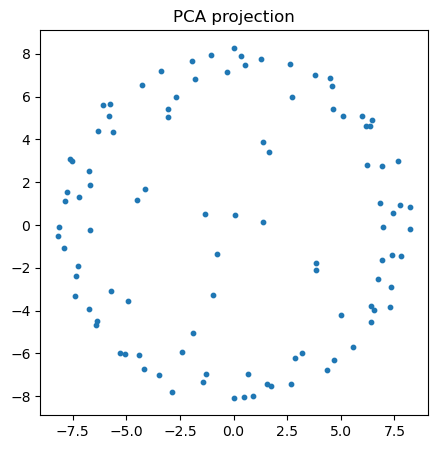

In [36]:
pca = PCA(n_components=2).fit(data6)

P = pca.components_
P = P.T
X_pca = data6 @ P
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_pca[:,0], X_pca[:,1], s = 10)
ax.set_title('PCA projection')
plt.show()

In [37]:
from tqdm import tqdm
import torch
from torch_tda.nn import RipsLayer, Rips0Layer, BottleneckLayer, WassersteinLayer, BarcodePolyFeature
from herabottleneck import BottleneckLayerHera

def cayley_opt(X, P=None, lrs=None, pca_wt=0.1):
    """
    Optimize projection
    
    Inputs:
        X: data
        P: Initial projection.  If None, will initialize with PCA
        lrs: sequence of learning rates
        
    Returns:
        P: projection
        losses: sequence of losses
        db: sequence of bottleneck distances
    """
    if P is None:
        pca = PCA(n_components=2).fit(X)
        P = pca.components_
        P = P.T
        
    if lrs is None:
        lrs = np.hstack((np.repeat(1e-3,15), np.repeat(1e-4,65), np.repeat(1e-5,10)))
        
    Pt = torch.tensor(P, dtype=torch.double, requires_grad=True)
    
    Xt = torch.tensor(X, dtype=torch.double)
    layer = RipsLayer(maxdim=1, metric = 'euclidean')
    ground_truth_dgm = layer(Xt)
    
    crit = BottleneckLayerHera()
    
    losses = []
    db = []
    for lr in tqdm(lrs):
        Yt = torch.mm(Xt, Pt)
        Y_dgm = layer(Yt)
        #bd0 = crit(Y_dgm[0], ground_truth_dgm[0])
        bd1 = crit(Y_dgm[1], ground_truth_dgm[1])
        
        n = Yt.shape[0]
        pca_loss = (1/n * torch.pow(torch.linalg.norm(Yt, 'fro'), 2) )
        
        #loss = bd0 + bd1
        loss = bd1 + pca_wt * pca_loss
        losses.append(loss.detach().numpy())
        db.append(bd1.detach().numpy())
        
    #     print(loss.detach().numpy())

        try:
            Pt.grad.zero_()
        except:
            pass

        loss.backward()

        # detach from torch to do update
        dP = Pt.grad.detach().numpy()
        P = cayley_update(P, dP, lr)
        # put back in tensor
        Pt.data = torch.tensor(P)
        
    
    # append final bottleneck distance and loss
    Yt = torch.mm(Xt, Pt)
    Y_dgm = layer(Yt)
    #bd0 = crit(Y_dgm[0], ground_truth_dgm[0])
    bd1 = crit(Y_dgm[1], ground_truth_dgm[1])

    n = Yt.shape[0]
    pca_loss = (1/n * torch.pow(torch.linalg.norm(Yt, 'fro'), 2) )

    #loss = bd0 + bd1
    loss = bd1 + pca_wt * pca_loss
    losses.append(loss.detach().numpy())
    db.append(bd1.detach().numpy())
    
        
    return Pt.detach().numpy(), losses, db
        

lrs = np.hstack((np.repeat(1e-3,10), np.repeat(1e-4,10),np.repeat(1e-5,10)))
P2, losses, db = cayley_opt(data6, lrs=lrs, pca_wt=0.001)

100%|██████████| 30/30 [00:02<00:00, 11.28it/s]


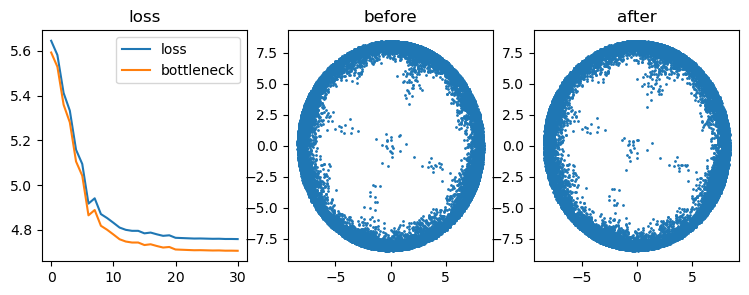

In [40]:
fig, ax = plt.subplots(1,3,figsize=(9,3))

ax[0].plot(losses, label='loss')
ax[0].plot(db, label='bottleneck')
ax[0].set_title('loss')
ax[0].legend()

X_0 = data4 @ P
ax[1].scatter(X_0[:,0], X_0[:,1], s=1)
ax[1].set_title('before')

X_ph = data4 @ P2
ax[2].scatter(X_ph[:,0], X_ph[:,1], s=1)
ax[2].set_title('after')

plt.show()

In [41]:
db[0], db[-1]

(array(5.59222186), array(4.70560723))

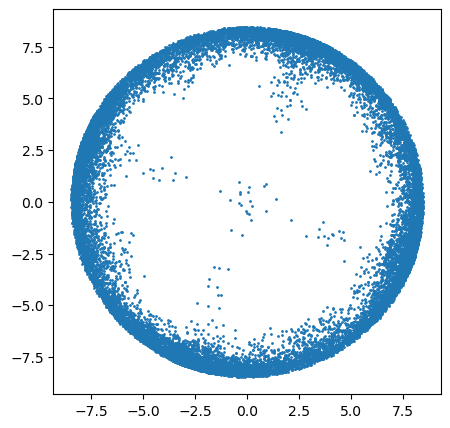

In [44]:
plt.figure(figsize=(5,5))
plt.scatter(X_0[:,0], X_0[:,1], s=1)
plt.savefig('../images/VH/pca_before.pdf')
plt.show()

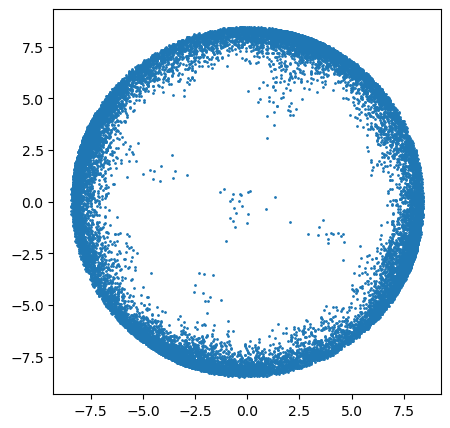

In [45]:
plt.figure(figsize=(5,5))
plt.scatter(X_ph[:,0], X_ph[:,1], s=1)
plt.savefig('../images/VH/pca_after.pdf')
plt.show()

In [46]:
P.T @ P2

array([[ 0.99552918, -0.00231971],
       [-0.00139691,  0.99911991]])

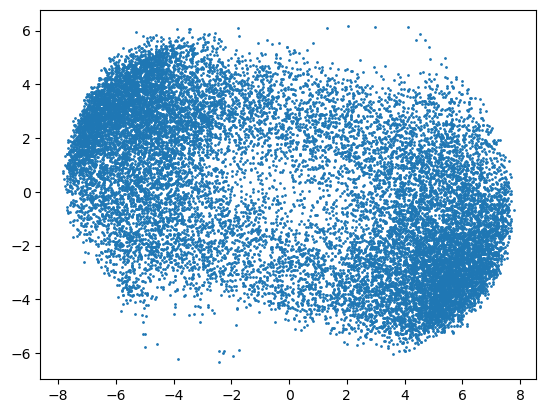

In [47]:
def random_projection(m, n):
    A = np.random.randn(m,n)
    Q, r = np.linalg.qr(A)
    return Q

np.random.seed(0)
P3 = random_projection(8,2)
X_rand = data4 @ P3
plt.scatter(X_rand[:,0], X_rand[:,1], s=1)
plt.show()

In [48]:
# lrs = np.hstack((np.repeat(1e-3,40), np.repeat(1e-4,20)))
# lrs = np.hstack((np.repeat(1e-3,100), np.repeat(1e-4,20)))
lrs = np.hstack((np.repeat(1e-3,150), np.repeat(1e-4,20)))
P4, losses, db = cayley_opt(data6, P=P3, lrs=lrs, pca_wt=0.001)

100%|██████████| 170/170 [00:39<00:00,  4.29it/s]


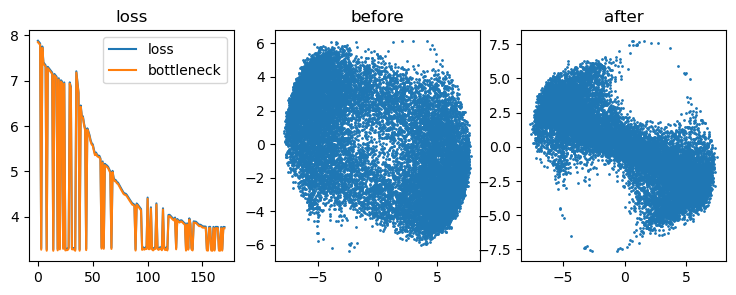

In [49]:
fig, ax = plt.subplots(1,3,figsize=(9,3))

ax[0].plot(losses, label='loss')
ax[0].plot(db, label='bottleneck')
ax[0].set_title('loss')
ax[0].legend()

X_0 = data4 @ P3
ax[1].scatter(X_0[:,0], X_0[:,1], s=1)
ax[1].set_title('before')

X_ph = data4 @ P4
ax[2].scatter(X_ph[:,0], X_ph[:,1], s=1)
ax[2].set_title('after')

plt.show()

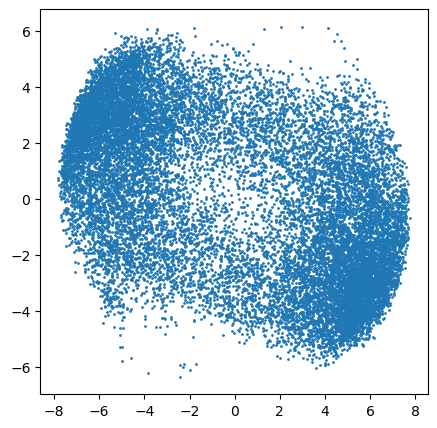

In [50]:
plt.figure(figsize=(5,5))
plt.scatter(X_0[:,0], X_0[:,1], s=1)
plt.savefig('../images/VH/rand_before.pdf')
plt.show()

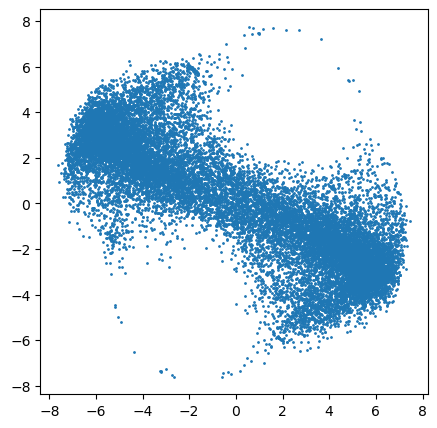

In [231]:
plt.figure(figsize=(5,5))
plt.scatter(X_ph[:,0], X_ph[:,1], s=1)
plt.savefig('../images/VH/rand_after.pdf')
plt.show()

In [234]:
db[0], db[-1], np.min(db), 

(array(7.85268795), array(3.74275491), 3.245076318698868)